# Hackathon #1 - Binary Classification - Template
Always check the [Reference Document](https://docs.google.com/document/d/1A-1-UK9ol4tegfU4YQySEiBXBeqbx_tu1qdmiMAzNCM/edit?usp=sharing) for all information ;) 

Remember to keep your workflow consistent!

## Regarding the Data
- The dataset can be loaded with `load_data()` (check the already provided code below). It will output two dataframes:
  - `train`: labeled dataset (with target) 
  - `test`: unlabeled dataset (target is not available)
- You will use the `train` data to do your magic! When you are finished and have a predictive model you will have to make predictions using the `test` data and submit it to our platform (where you will get a AUC value - kind of what happens in Kaggle competitions). Check the file `submission_example.csv` for an example and the [Reference Document](https://docs.google.com/document/d/1A-1-UK9ol4tegfU4YQySEiBXBeqbx_tu1qdmiMAzNCM/edit?usp=sharing) for further information.
- You can and should perform train-test splits on the `train` data that you have available. Cross-validation is highly recommended. 
- The target name is `TomorrowRainForecast`: it is either 1 (rains tomorrow) and 0 (does not rain tomorrow).
- The `ID` is the identification variable which is very important for keeping track of the predictions you will make on the `test` data.

*Good luck,  
LDSA team*

In [2]:
# some useful imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def load_data(data_dir='../data/'):
    train = pd.read_csv(data_dir+'train.csv')
    test = pd.read_csv(data_dir+'test.csv')
    return train, test

# 1. Load Data
Load the `train` and `test` datasets

In [4]:
train, test = load_data()

In [5]:
train.head()

,ID,AmountRain,StrongWindDir,StrongWindSpeed,MorningWindDir,AfternoonWindDir,AfternoonWindSpeed,MorningHumidity,AfternoonHumidity,MorningTemp,AfternoonTemp,DidRainToday,DaysSinceNewYear,TomorrowRainForecast
0,5683,0.0,WSW,43.0,N,SW,17.0,82.0,51.0,15.4,20.8,No,268,0
1,2971,0.0,E,15.0,NaN,SE,7.0,91.0,63.0,9.7,16.6,No,136,0
2,3560,0.0,S,33.0,WSW,WSW,17.0,58.0,38.0,10.9,15.9,No,217,0
3,2304,10.0,NE,30.0,S,SSE,11.0,96.0,93.0,4.7,6.4,Yes,195,1
4,3573,0.0,WSW,48.0,NaN,SW,26.0,59.0,40.0,11.5,15.9,No,232,0


# Do your magic!

Text(0.5,1,'Y Imbalanced Dataset')

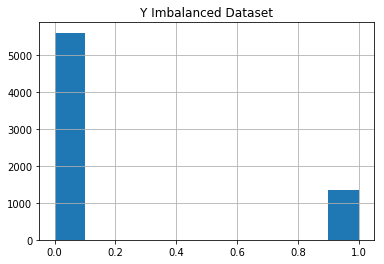

In [11]:
train.TomorrowRainForecast.hist()
plt.title('Y Imbalanced Dataset')

,ID,AmountRain,StrongWindSpeed,AfternoonWindSpeed,MorningHumidity,AfternoonHumidity,MorningTemp,AfternoonTemp,DaysSinceNewYear,TomorrowRainForecast
count,6953.000000,6880.000000,6914.000000,6922.000000,6917.000000,6917.000000,6930.000000,6928.000000,6953.000000,6953.000000
mean,3476.000000,1.944041,33.697426,14.122797,72.891427,47.636114,15.767547,22.219125,177.365741,0.193586
std,2007.302543,6.586221,12.883869,7.251122,18.690028,19.940125,6.002202,6.954120,104.510654,0.395136
min,0.000000,0.000000,7.000000,0.000000,6.000000,1.000000,0.300000,6.400000,0.000000,0.000000
25%,1738.000000,0.000000,24.000000,9.000000,60.000000,33.000000,11.100000,16.700000,86.000000,0.000000
50%,3476.000000,0.000000,31.000000,13.000000,74.000000,46.000000,15.900000,21.500000,174.000000,0.000000
75%,5214.000000,0.400000,41.000000,19.000000,87.000000,60.000000,20.100000,27.200000,267.000000,0.000000
max,6952.000000,116.000000,107.000000,56.000000,100.000000,100.000000,37.600000,43.700000,365.000000,1.000000
